# Wavelength calibration 

Here we compute the pixel-to-wavelength mapping for TrES-3 and the comparison star spectra using the three arc frames (Xe, HgAr, and Ne) taken in the beginning of the night. We assume that the mapping does not change during the night.

**Note:** The spectra have been reduced by Grzegorz Nowak (IAC) using IRAF routines, and the extraction included wavelength calibration (using IRAF's [ecidentify](http://iraf.net/irafhelp.php?val=echelle.ecidentify&help=Help+Page)). However, it doesn't hurt to do this again manually.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyfits as pf
import pandas as pd

from glob import glob
from os.path import join
from cPickle import dump

from scipy.optimize import fmin_powell
from numpy.polynomial.chebyshev import Chebyshev

from pyfc import psf_g1d
from core import *

rc('font', size=6)
rc('axes', labelsize=8)
rc('ytick', labelsize=8)
rc('xtick', labelsize=8)
rc('axes', titlesize=10)

datadir = 'data'

In [4]:
class CalibrationSpectrum(object):
    def __init__(self, name, spectrum, lines, initial_guess=None):
        self.name = name
        self.spectrum = spectrum
        self.lines = lines
        self.initial_guess = array(initial_guess)
        self.nlines = len(lines)
        self._model = zeros_like(self.spectrum)
        self.pixel  = arange(spectrum.size)
        self.wl     = zeros_like(self.pixel)
        self.solution = WavelengthSolution()
        self._fit_result = None
        
        self.pixel_to_wl = self.solution.pixel_to_wl
        self.wl_to_pixel = self.solution.wl_to_pixel

        
    def model(self, pv):
        self._model.fill(0.)
        for i in xrange(self.nlines):
            self._model += psf_g1d(pv[1+i*2], pv[2+i*2], pv[0], self._model.size)
        return self._model
    
    def plot(self):
        fig,ax = subplots(1,self.nlines,figsize=(13,2), sharey=True)
        cns = self.fitted_centers
        for i in range(self.nlines):
            sl = s_[cns[i]-10: cns[i]+10]
            ax.flat[i].plot(self.pixel[sl], self.spectrum[sl])
            ax.flat[i].plot(self.pixel[sl], self.model(self._fit_result)[sl])
            setp(ax.flat[i], xlim=self.pixel[sl][[0,-1]])
        fig.tight_layout()
      
    def chi_sqr(self, pv):
        return ((self.spectrum-self.model(pv))**2).sum()
    
    def fit(self, minargs={}, disp_min=False):
        self._fit_result = fmin_powell(self.chi_sqr, self.initial_guess, disp=disp_min, **minargs)
        self.solution.fit(self.fitted_centers, self.lines) 
            
    @property
    def fitted_centers(self):
        return self._fit_result[1::2]
    
    
class WLFitter(object):
    def __init__(self, spectra):
        self.spectra = spectra
        self.lines = concatenate([s.lines for s in self.spectra])
        self.solution = WavelengthSolution()
        
        self.pixel_to_wl = self.solution.pixel_to_wl
        self.wl_to_pixel = self.solution.wl_to_pixel
    
    def fit(self):
        [s.fit() for s in self.spectra]
        lines_fit = self.fitted_centers
        lines_ref = self.lines
        sids = argsort(lines_ref)
        self.solution.fit(lines_fit[sids], lines_ref[sids])
        
    @property
    def fitted_centers(self):
        return concatenate([s.fitted_centers for s in self.spectra])

## Read in the arc frames

In [5]:
arcs = sorted(glob(join(rawdir,'arc','*fits')))
arc1 = dstack([pf.getdata(arc,1) for arc in arcs])
arc2 = dstack([pf.getdata(arc,2) for arc in arcs])
arct = [pf.getval(arc, 'object') for arc in arcs]

In [6]:
arct

['ArcLamp_HgAr', 'ArcLamp_Ne', 'ArcLamp_Xe']

## Create a linelist dataframe

In [7]:
lcenters, lnames = [], []
with open('data/spec_linelist.txt','r') as f:
    for l in f.readlines():
        ls = l.split()
        lcenters.append(float(ls[1])*1e-1)
        lnames.append(ls[3])

lines = pd.DataFrame(lnames, columns=['element'])
lines['center'] = lcenters

lines_xe   = array(lines[lines.element=='XeI'].center)
lines_hgar = array(lines[(lines.element=='HgI') | (lines.element=='ArI')].center)
lines_ne   = array(lines[lines.element=='NeI'].center)

## Plot the science and arc frames 

In [8]:
sl1 = s_[275:295]
sl2 = s_[855:875]

In [9]:
f = pf.open(join(rawdir,'object','0000706077-20140825-OSIRIS-OsirisLongSlitSpectroscopy.fits'))
ccd1 = f[1].data
ccd2 = f[2].data
f.close()

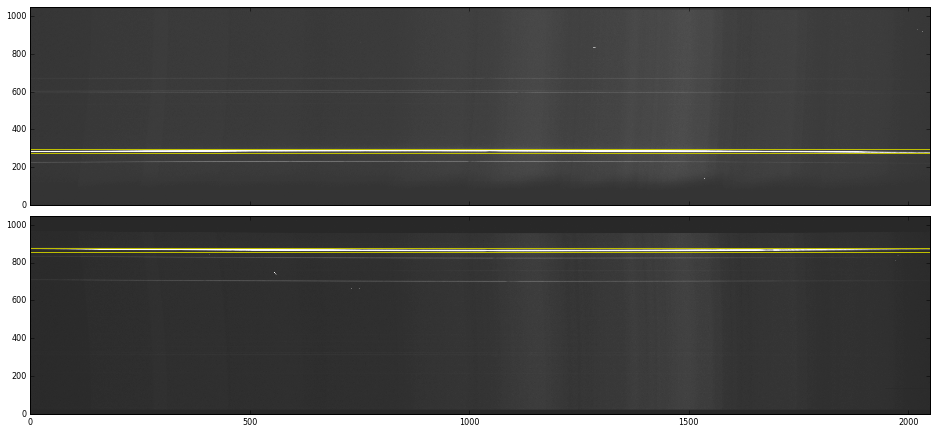

In [10]:
fig,ax = subplots(2,1,figsize=(13,6), sharex=True)
ax[0].imshow(ccd1.T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
ax[0].axhspan(sl1.start, sl1.stop, fill=False, edgecolor='y', lw=1)
ax[1].imshow(ccd2.T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
ax[1].axhspan(sl2.start, sl2.stop, fill=False, edgecolor='y', lw=1)
setp(ax, ylim=(0,arc1.shape[1]))
fig.tight_layout()

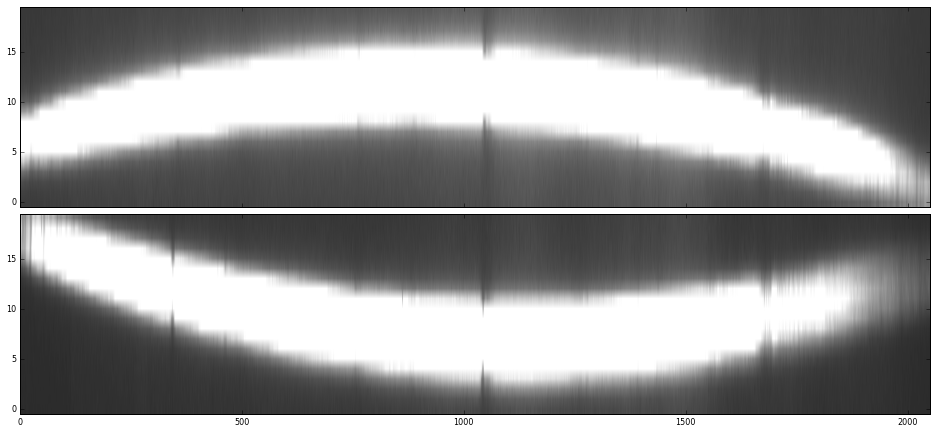

In [11]:
fig,ax = subplots(2,1,figsize=(13,6), sharex=True)
ax[0].imshow(ccd1[:,sl1].T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
ax[1].imshow(ccd2[:,sl2].T, cmap=cm.gray, aspect='auto', origin='image', vmin=500, vmax=4000)
#setp(ax, ylim=(0,arc1.shape[1]))
fig.tight_layout()

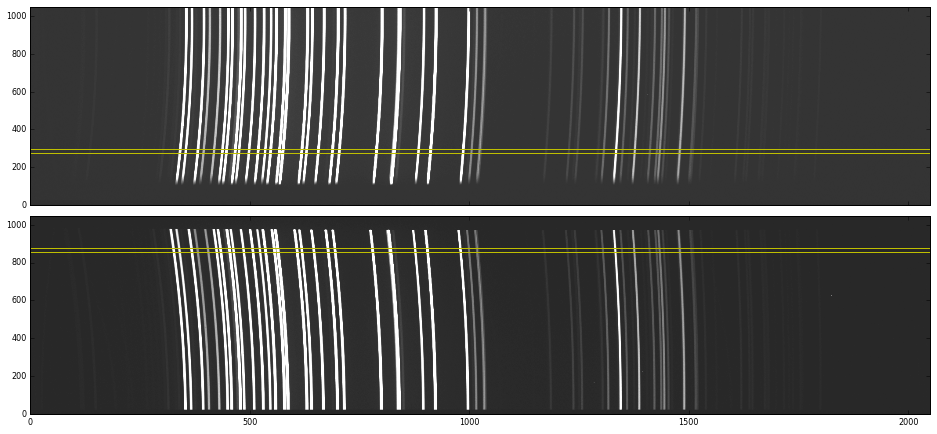

In [12]:
fig,ax = subplots(2,1,figsize=(13,6),sharex=True)
ax[0].imshow(arc1[:,:,1].T, aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
ax[0].axhspan(sl1.start, sl1.stop, fill=False, edgecolor='y', lw=1)
ax[1].imshow(arc2[:,:,1].T, aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
ax[1].axhspan(sl2.start, sl2.stop, fill=False, edgecolor='y', lw=1)
setp(ax, ylim=(0,arc1.shape[1]))
fig.tight_layout()

In [17]:
def subtract_median(a):
    return a-median(a)

class CCDFitter(object):
    def __init__(self, arc, sl):
        self.spectrum_xe   = subtract_median(arc[:,sl,2].mean(1))
        self.spectrum_hgar = subtract_median(arc[:,sl,0].mean(1))
        self.spectrum_ne   = subtract_median(arc[:,sl,1].mean(1))

        cs_xe = CalibrationSpectrum('XeI', self.spectrum_xe, lines_xe, 
                            [7, 1280, 3.7e4,  1299, 2.0e4,  1490, 6.0e4,  1540, 1.0e4,
                                1575, 1.5e4,  1620, 1.5e4,  1840, 1.0e4,  1878, 0.5e4])

        cs_hgar = CalibrationSpectrum('HgAr', self.spectrum_hgar, lines_hgar, 
                            [7,  165, 4.0e4,   305, 1.0e4,   315, 1.0e4,  1055, 2.0e4, 
                                1090, 1.0e4,  1235, 1.5e4])

        cs_ne1 = CalibrationSpectrum('NeI1', self.spectrum_ne, lines_ne[:12], 
                            [7, 341, 6.0e3,  353, 5.0e3,  381, 7.0e3, 395, 3.0e3,
                                418, 3.0e3,  437, 1.0e4,  446, 1.0e4, 466, 1.0e4,
                                475, 1.0e4,  497, 5.0e3,  518, 1.0e4, 534, 5.0e3])

        cs_ne2 = CalibrationSpectrum('NeI2', self.spectrum_ne, lines_ne[12:20], 
                            [7, 546, 1.5e4,  566, 2.0e4,  575,  4.0e4,  617, 2.5e4,
                                628, 1.0e4,  655, 1.0e4,  687,  2.0e4,  702, 2.0e4])
      
        self.wlf = WLFitter([cs_xe, cs_hgar, cs_ne1, cs_ne2])#, cs_hgar, cs_ne1, cs_ne2])
        
        
    def fit(self):
        self.wlf.fit()

In [18]:
ccd1f = CCDFitter(arc1, sl1)
ccd2f = CCDFitter(arc2, sl2)

ccd1f.fit()
ccd2f.fit()

In [19]:
for s in ccd2f.wlf.spectra:
    s.initial_guess[1::2] -= 12
ccd2f.fit()

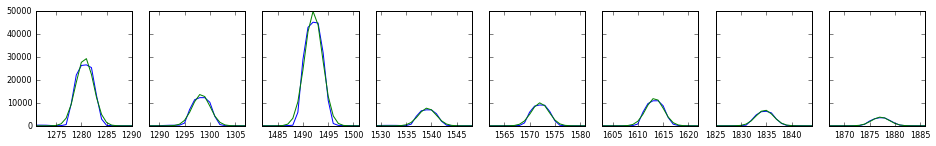

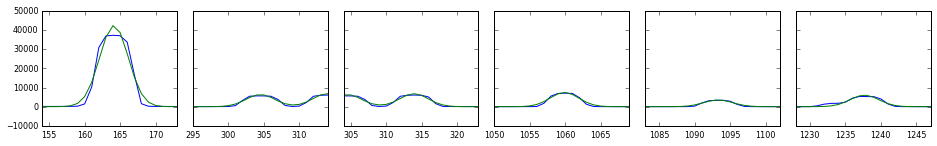

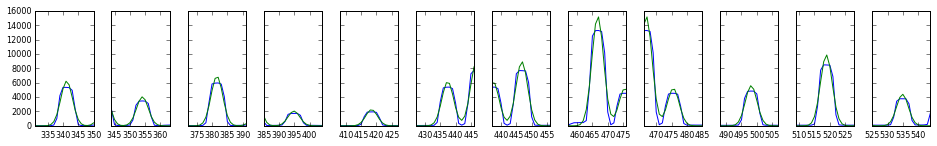

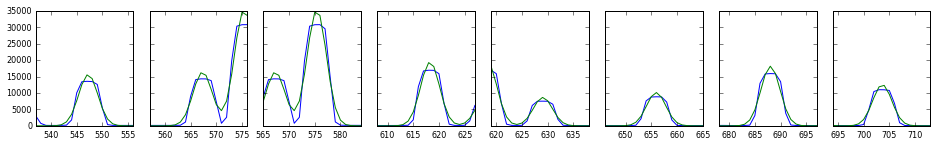

In [20]:
[s.plot() for s in ccd1f.wlf.spectra];

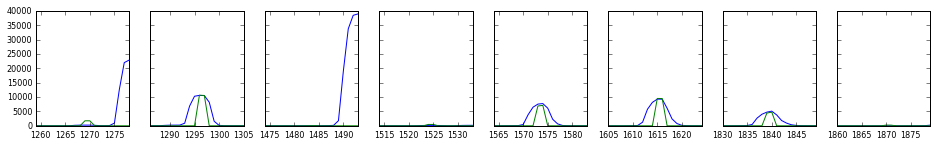

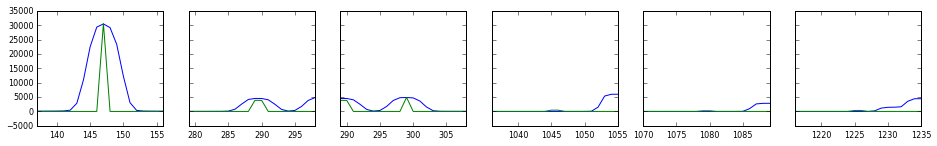

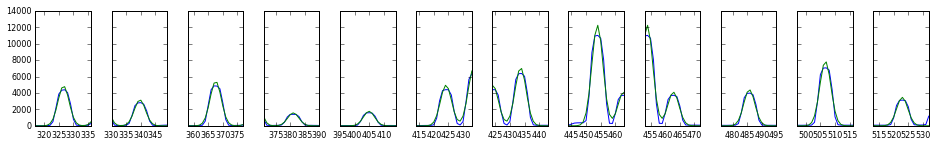

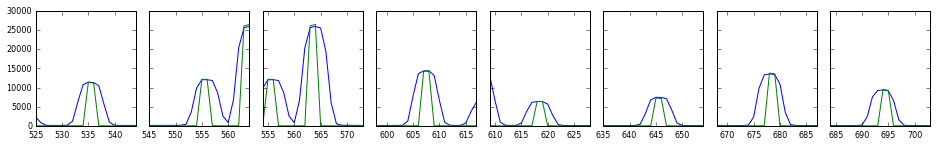

In [21]:
[s.plot() for s in ccd2f.wlf.spectra];

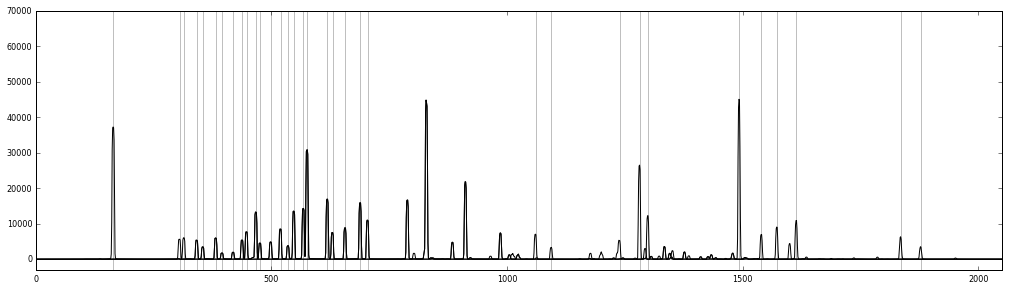

In [22]:
fig,ax = subplots(1,1,figsize=(14,4))
[axvline(l, c='k', alpha=0.25, ymax=1) for l in ccd1f.wlf.wl_to_pixel(ccd1f.wlf.lines)]
[ax.plot(s.spectrum, c='k', lw=1) for s in ccd1f.wlf.spectra]
setp(ax, xlim=(0, ccd1f.wlf.spectra[0].spectrum.size), ylim=(-3e3,7e4))
fig.tight_layout()

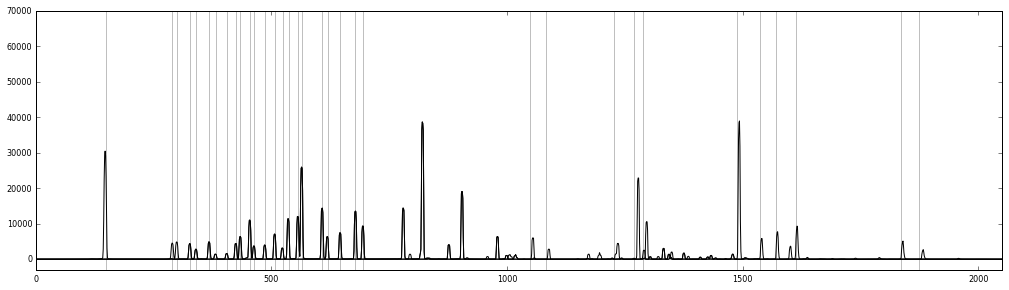

In [23]:
fig,ax = subplots(1,1,figsize=(14,4))
[axvline(l, c='k', alpha=0.25, ymax=1) for l in ccd2f.wlf.wl_to_pixel(ccd2f.wlf.lines)]
[ax.plot(s.spectrum, c='k', lw=1) for s in ccd2f.wlf.spectra]
setp(ax, xlim=(0, ccd1f.wlf.spectra[0].spectrum.size), ylim=(-3e3,7e4))
fig.tight_layout()

In [25]:
with open('results/wl_calibration.pkl', 'w') as f:
    dump(dict(ccd1=ccd1f.wlf.solution,
              ccd2=ccd2f.wlf.solution), f)

---

<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>